# MTG Set Complexity Analysis

I've had an on-off relationship with Magic the Gathering since I was a kid. Discovering [ornithopter](https://scryfall.com/card/3ed/270/ornithopter) felt like literal magic to 11 year old me. I loathed chores but would _happily_ volunteer for extra work to scrape together a few dollar bills I could run with to my local comic shop, crack a pack, and hopefully land a [Shivan Dragon](https://scryfall.com/card/3ed/177/shivan-dragon) or [Nightmare](https://scryfall.com/card/3ed/120/nightmare).

Eventually I got more interested in girls than collectable card games. To 90's teenage me it felt like I really had to choose between the two so I packed the cards away. A decade later while laid up with an injury I checked in on my old childhood game, found MTGO, and spent my recovery time furiously playing and trading Ravnica: City of Guilds. Fast forward another decade and I pop into the new game store that opened in my neighborhood, buy a bunch of Battle for Zendikar packs, realize cracking packs is still hella fun but that I have no one to play with, and pack it up again.

Recently a friend got me onto Twitch, which is filled with all sorts of nonsense the kids (get off my lawn) seem to like these days. Digging around for something more interesting than Fortnite I ran across MTG Arena streamers, quickly downloaded Arena myself, and fired it off for some good old times.

I played Zendikar Rising, found a community online to draft a bunch with, and generally had a good time. The game was certainly more complicated than when I was a kid (what are these plainswalker things??!?) but things were manageable. Then Kaldheim came out.

Maybe it was just the set being new, but things felt way more complicated and I felt clock pressure like I never did with Zendikar Rising. Losing matches to the clock is no fun.

Feelings are one thing, but why bother with squishy human _feelings_ when we have cold hard _data_ to work with!? Turns out [Scryfall](https://scryfall.com/) maintains delicious [bulk data files](https://scryfall.com/docs/api/bulk-data), including a JSON file of all cards, ever.

*&ast;pops knuckles\&ast;*

## Elbow deep in 306,398 Magic Cards

How have Magic sets changed over time? Are newer sets more complicated than older sets? Let's load up the data and muck about!

We'll start off with some boilerplate imports and display settings.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re as re
import seaborn as sns
import statsmodels.api as sm
import warnings

%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Set some convenient display options.
pd.options.display.max_rows = 80
pd.options.display.max_columns = 80

The data we're working with is the "All Cards" JSON file available at Scryfall's bulk data page. This particular file comes from February 6th, 2021. If for some crazy reason you want this exact file [contact me](https://www.grae.io/#contact) and I'll email it to you.

In [3]:
# Load data. This takes a bit.
# Source: "All Cards" download from https://scryfall.com/docs/api/bulk-data
df = pd.read_json("data/all-cards-20210206221317.json")

In [4]:
# Copy df so we don't need to reload from JSON as we tinker.
data = df.copy()

## Exploring & cleaning

Before we can start analyzing cards we need to decide what a "card" is. This data set has 306,398 "card objects". That seems like way higher than the number of individual magic cards. For our purposes we'll filter out:
  * **Non-English language cards**: [Stonework Packbeast](https://scryfall.com/card/znr/255/stonework-packbeast) and [Mauerwerk-Packbestie](https://scryfall.com/card/znr/255/de/mauerwerk-packbestie) are just one card.
  * **Sets that aren't "Core" or "Expansion" sets**: We'll focus on the basics and ignore ["Other"](https://en.wikipedia.org/wiki/List_of_Magic:_The_Gathering_sets#Other_sets) sets like Modern Masters, Un-Sets, or [Secret Lair](https://scryfall.com/search?order=set&q=set%3Asld+%28cn%3A133+or+cn%3A134+or+cn%3A135+or+cn%3A136+or+cn%3A137%29&unique=prints).
  * **Non-booster cards**: [Rampage of the Valkyries](https://scryfall.com/card/khm/393/rampage-of-the-valkyries) seems rad but it isn't in limited so I don't care about it.
  * **Basic lands**: There, uh, there are a lot of basic land card objects in our data. We can ignore these.
  * **Alternate art**: We'll count the various versions of ([Guildgates](https://scryfall.com/search?q=simic+guildgate+s%3Drna&unique=prints&as=grid&order=released), [Dwarven Soldier](https://scryfall.com/search?q=%21%22Dwarven+Soldier%22+s%3DFEM&unique=prints&as=grid&order=released), etc.) as the same card.
  * **Foils**: A boring regular [Zagras](https://scryfall.com/card/znr/241/zagras-thief-of-heartbeats) hits just as hard as a fancy foil Zagras.
  * **Print variations & misprints**: We don't particularly care about the [blue-bordered Hurricane](https://scryfall.com/card/sum/202/hurricane).
  * **Teferi, all the Teferi**: For unholy reasons known only to the WotC marketing department, there are [SIXTEEN different versions of Teferi, Master of Time](https://scryfall.com/search?q=Teferi%2C+Master+of+Time&unique=prints&as=grid&order=released) in M21. Wat. Drop all but one.

We also need to decide how to treat cards with **multiple card faces**, like [Bonecrusher Giant // Stomp](https://scryfall.com/card/eld/115/bonecrusher-giant-stomp|) and  [Halvar, God of Battle // Sword of the Realms](https://scryfall.com/card/khm/15/halvar-god-of-battle-sword-of-the-realms). For our purposes we'll consider each piece of cardboard to be a single card, so we'll attribute all data from all card faces to that card.

Time to code things up!

In [5]:
# Remove non-English language cards.
data = data[data['lang'] == 'en']

In [6]:
# We only care about core sets & expansion sets.
data = data.loc[data['set_type'].isin(['expansion', 'core'])]

In [7]:
# Remove cards you can't open in boosters. This removes a lot of duplicates.
data = data[data['booster'] == True]

In [8]:
# Drop basic lands.
data = data[~((data['type_line'].str.contains('Basic')) & (data['type_line'].str.contains('Land')))]

In [9]:
# Some cards have alternate art/flavor text and different collector numbers.
# See Dwarven Soldier from Fallen Empires w/collector_numbers '53a', '53b', '53c', and '53d'.
# Keep version 'a' and drop any other versions.
data = data[~data['collector_number'].str.contains('b|c|d')]

# There are alternate art guildgates from RNA and GRN that I can't find a better way to filter.
alternate_guildgates = set([
    'e52013ba-9b17-497b-a844-1e7eb5607019',
    'c52ceefc-90d0-49d1-ae54-9a4eab819849',
    'b7129bdf-de02-4ed2-b5de-f774b8a7d302',
    'f0a021e9-b11a-4028-86c9-01b62eae1877',
    '8fffd445-de4f-45de-95b9-6e0855926a6a',
    'fc36bb2a-115d-4e24-a1e9-02b21773e945',
    'f7046b5e-622f-4ae8-9ddd-709ccd61000e',
    'd88b90fa-a7f1-4739-a507-d22dede9384f',
    'ee1db693-5dd9-48de-8520-014d9ad5b596',
    '6e73e082-b16a-45d5-bc4a-24c694b0b9af'
])
data = data[~data['id'].isin(alternate_guildgates)]

In [10]:
# Foils have a '★' character in their collector number. Drop these.
data = data[~data['collector_number'].str.contains('★')]

In [11]:
# Drop print variations. We don't care about misprints or extra-dark mana symbols.
data = data[data['variation'] == False]

In [12]:
# Manually drop all but one of the 16 versions of Teferi, Master of Time in M21.
data = data[~(
    (data['name'] == 'Teferi, Master of Time') &
    (data['id'] != '9c0c61e3-9f3d-4e7f-9046-0ea336dd8a2d')
)]

By this point we should be down to just one version of each card in each set. It's possible I've somehow been too aggressive in my filtering. If you think I might have stripped out cards that should be included [drop me a line](https://www.grae.io/#contact)!


### Pruning columns
Scryfall gives us a lot of columns we don't care about. We can safely drop things related to price, etc. and just keep the columns that might be relevant.

In [13]:
# Drop unnecessary columns. See documentation at: https://scryfall.com/docs/api/cards
# We're dropping a lot, so name columns to keep.

kept_columns = ['all_parts', 'artist', 'booster', 'cmc', 'collector_number',
       'colors', 'flavor_text', 'frame_effects', 'full_art', 'id', 'illustration_id',
       'keywords', 'lang', 'layout', 'loyalty', 'mana_cost', 'card_faces',
       'name', 'nonfoil', 'oracle_id', 'oracle_text', 'power', 'printed_name',
       'produced_mana', 'promo', 'promo_types', 'rarity', 'released_at',
       'reprint', 'reserved', 'set', 'set_name', 'set_type', 'story_spotlight', 'textless',
       'toughness', 'type_line', 'variation', 'variation_of', 'watermark']

dropped_columns = [column for column in data.columns if column not in kept_columns]
data.drop(dropped_columns, inplace=True, axis=1)

### Missing data
Finally, we can clean up null / missing data so that our aggregate functions don't complain about incompatible data types.

In [14]:
# Replace empty values with the appropriate data type (e.g. empty string, list).

feature_types = {
    'mana_cost': '',
    'oracle_text': '',
    'colors': [],
    'power': '',
    'toughness': '',
    'flavor_text': '',
    'illustration_id': '',
    'printed_name': '',
    'all_parts': [],
    'promo_types': [],
    'loyalty': '',
    'watermark': '',
    'frame_effects': [],
    'produced_mana': [],
    'card_faces': [],
    'variation_of': '',
}

for column in list(feature_types.keys()):
    isna = data[column].isna()
    data.loc[isna, column] = pd.Series([feature_types[column]] * isna.sum()).values

## Feature Engineering

Now that we've filtered out duplicates and got our data into reasonable shape, we can start analyzing. I'm going to focus on **word count** as a measure of complexity. Cards with more words are more complex. Sets with wordier cards, on average, are more complex than sets with fewer words.

Of course, word count is only a rough measure of complexity. A deeper analysis might look at the relative complexity of each set's keyword mechanics. [Foretell](https://mtg.fandom.com/wiki/Foretell) and [Boast](https://mtg.fandom.com/wiki/Boast) certainly seem like more complex mechanics than [Landfall](https://mtg.fandom.com/wiki/Landfall) and [Kicker](https://mtg.fandom.com/wiki/Kicker). Similarly, cards with multiple card-faces, like [dual-faced](https://scryfall.com/card/khm/50/cosima-god-of-the-voyage-the-omenkeel) or [adventure](https://scryfall.com/card/znc/61/beanstalk-giant-fertile-footsteps) cards, are more complex, even if they [don't have a lot of rules text](https://scryfall.com/card/soi/266/thraben-gargoyle-stonewing-antagonizer). [Drop me a line](https://www.grae.io/#contact) if you have ideas on how to measure these other kinds of complexity.

In order to get the word count for each card we'll have to process the data and add some new columns. The oracle text for cards with multiple card-faces is tucked away in a different place than regular cards, so we'll have to dig that out and process it separately.

Let's start off with some basic utility functions to count words in a chunk of text, remove explanatory parentheticals from the oracle text, and aggregate the oracle text from multiple card-faces.

In [15]:
# Basic function to count words in a chunk of text.
def word_count(text):
    if type(text) != str:
        return 0
    return len(text.split())


# We don't want the explanatory parentheticals in oracle text.
def remove_parentheticals(text):
    if type(text) != str:
        return text
    return re.sub(r'\([^)]*\)', '', text)


# Cards with multiple faces store the oracle text for each face in the 'card_faces' column.
def card_face_oracle_text(arr):
    if type(arr) == list:
        return ' '.join([card_face['oracle_text'] for card_face in arr])
    else:
        return ''

It's convenient to pull all the oracle text for multi-face cards out into its own column.

In [16]:
# Pull oracle text for multi-face cards out of 'card_faces' column and aggregate it.
data['card_faces_oracle_text'] = data.apply(
    lambda row: card_face_oracle_text(row['card_faces']),
    axis=1)

Now we can consolidate our two oracle text columns into one.

In [17]:
data['normed_oracle_text'] = data['oracle_text'] + data['card_faces_oracle_text']

And groom all the text.

In [18]:
# Groom all oracle text. Replace newlines with spaces and remove explanatory parentheticals.
data['normed_oracle_text'] = data['normed_oracle_text'].str.replace('\n', ' ').apply(remove_parentheticals)

With our groomed text we're _finally_ ready to see how many words each card has...

In [19]:
# Create word count columns to store word counts from the oracle text.
data['word_count'] = data['normed_oracle_text'].apply(word_count)

... and group the cards together by set to see how wordy each set is.

In [20]:
# Group by set and get average.
by_set = data.groupby('set_name').mean()
by_set.sort_values(by='word_count', inplace=True)
by_set['word_count']

set_name
Seventh Edition          10.133333
Ninth Edition            10.818182
Eighth Edition           10.954545
Classic Sixth Edition    12.078788
Tenth Edition            12.107438
                           ...    
Theros Beyond Death      23.931727
Fallen Empires           24.715686
Alliances                25.506944
Zendikar Rising          26.509434
Kaldheim                 28.094545
Name: word_count, Length: 109, dtype: float64

## Kaldheim: the wordiest set

Hey, it's not just me! It turns out that **Kaldheim is the most complex set ever released**, as measured by average word count per card. That said, I was surprised to see Zendikar Rising as the second-most complex set. It certainly felt simpler than this measure would imply.

Let's look at each of the 109 MTG sets in all their glory. How does your favorite stack up?

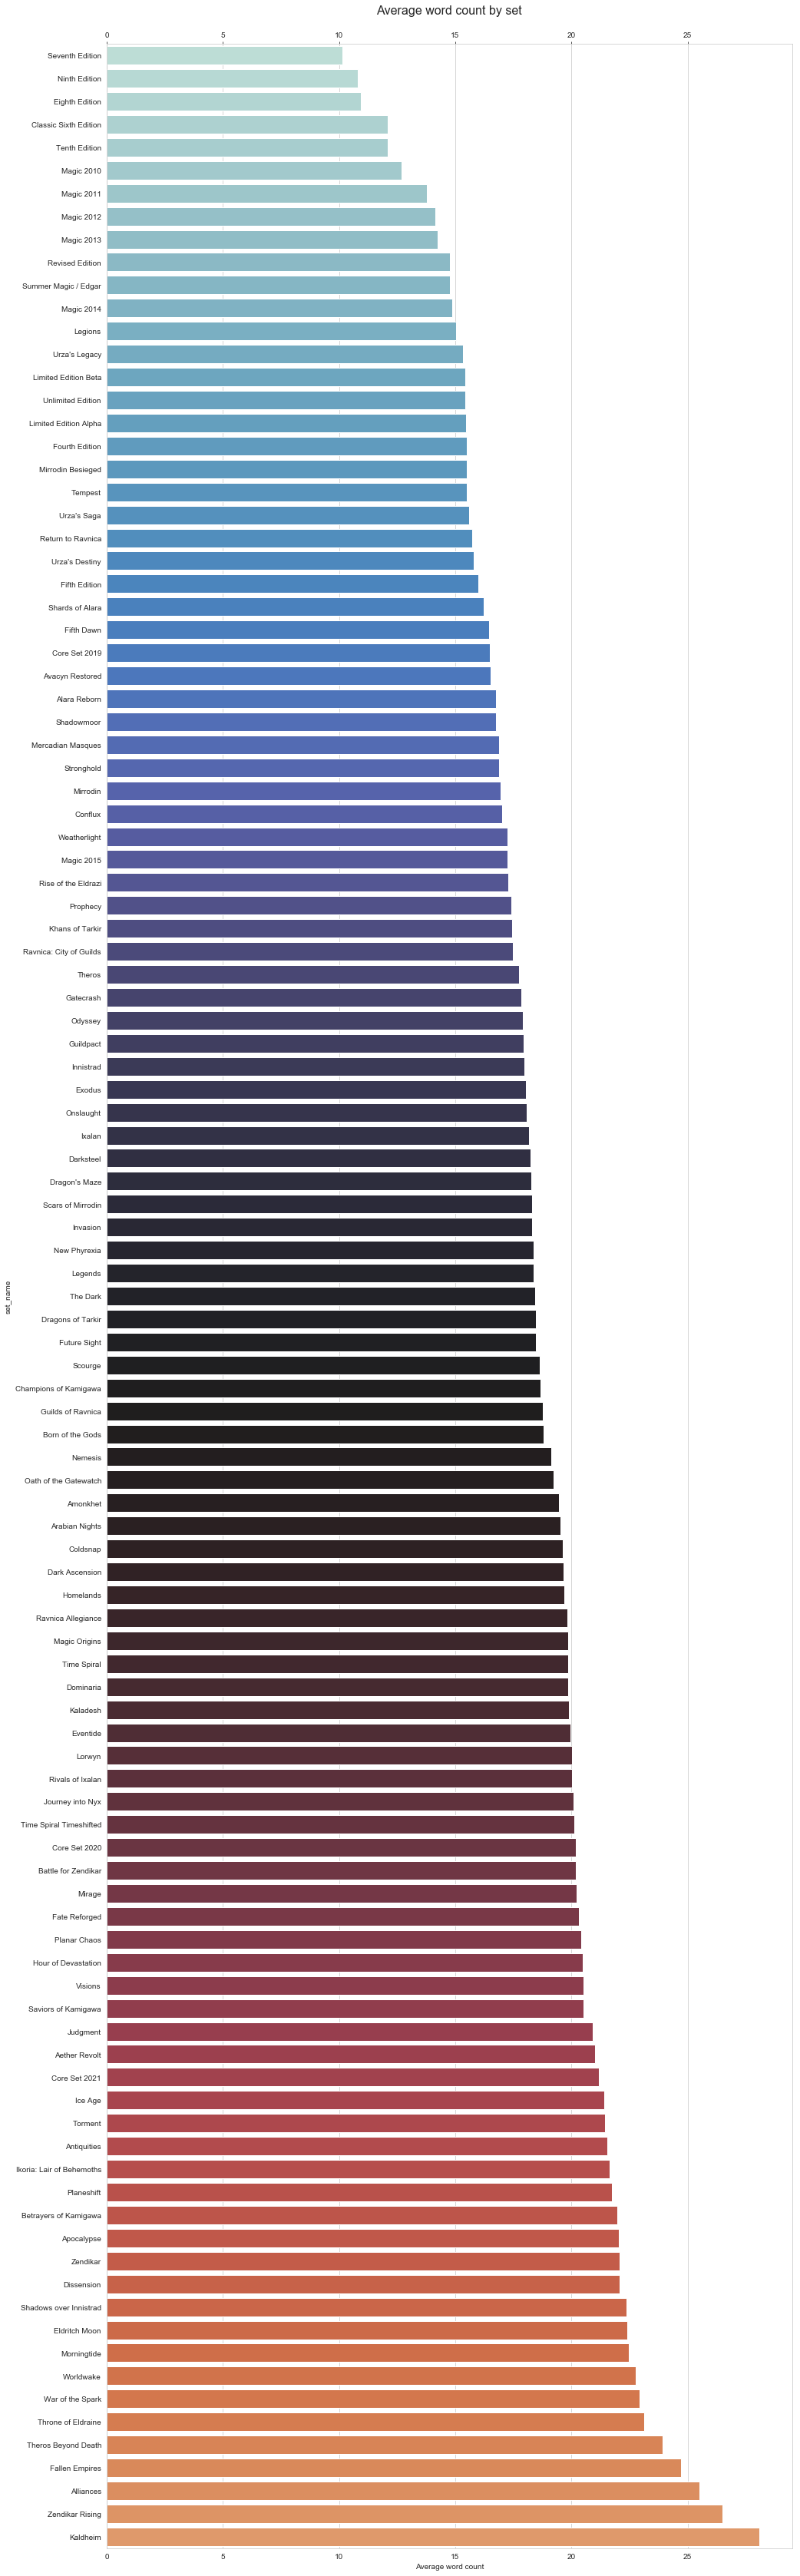

In [21]:
# Plot the average word count of each set core & expansion set.
sns.set_style("whitegrid")
sns.set_palette('mako')
plt.figure(figsize=(16, 60))
ax = sns.barplot(
    y=by_set.index,
    x=by_set['word_count'],
    palette=sns.color_palette('icefire', len(by_set)+ 10)
)
ax.tick_params(top=True, labeltop=True)
plt.title('Average word count by set', y=1.01, fontsize = 16)
plt.xlabel('Average word count')

plt.show()

## Expansion sets vs. core sets

The sets with the lowest word counts are all core sets. Let's look at core sets and expansion sets separately to see how they compare.

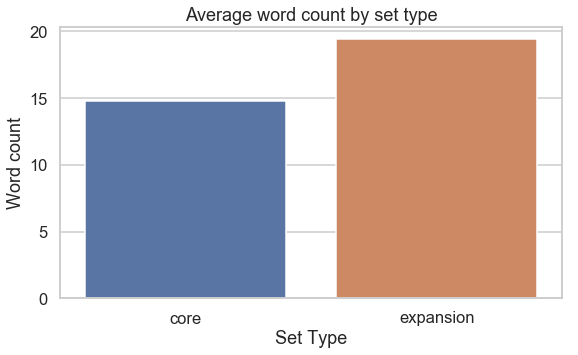

In [22]:
# Compare word counts for core sets and expansion sets.
by_set_type = data.groupby('set_type').mean()

sns.set_context('talk')

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x=by_set_type.index,
    y=by_set_type['word_count'],
    palette=sns.color_palette('deep', len(by_set_type))
)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Average word count by set type')
plt.xlabel("Set Type")
plt.ylabel('Word count')

plt.show()

That's a pretty big difference! Expansion sets have, on average, about 25% more words than core sets.


## Distribution

What kind of distribution do cards follow? Are there clusters around specifc word counts? Are there clear outliers? Let's see a histogram of cards by word count.

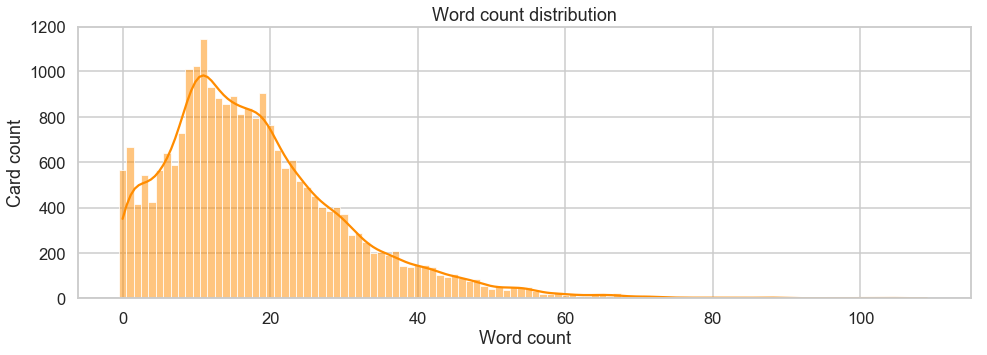

In [23]:
# What is the distribution of word count across all expansion & core sets?
# fig, ax = plt.subplots()
# ax.hist(data['normed_word_count'], bins=21, density=True)
# plt.show()
fig, ax = plt.subplots(figsize=(16, 5))

sns.histplot(
    data['word_count'],
    discrete=True,
    kde=True,
    color='darkorange'
)
plt.title('Word count distribution')
plt.ylabel('Card count')
plt.xlabel('Word count')

plt.show()

We can pull a few things out of this histogram:

### Word count isn't normally distributed
The distribution is [right-skewed](https://en.wikipedia.org/wiki/Skewness) rather than a nice, normal bell curve.

### There are a lot of low-count cards
This histogram is chonkier at the far left than a simple right-skew [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) would be.

Of course, it makes sens to see a bump at the low end. A lot of Magic cards have:
  * [No-text](https://scryfall.com/card/3ed/201/grizzly-bears),
  * Only a 1-word keyword like ["Hexproof"](https://scryfall.com/card/m12/194/sacred-wolf),
  * Only a 2-word keyword like ["First strike"](https://scryfall.com/card/4ed/53/tundra-wolves) or a simple keyword-value pair like ["Bushido": 1](https://scryfall.com/card/chk/42/samurai-enforcers)
  * 3-word simple abilities like [{T}: Add {G}.](https://scryfall.com/card/3ed/211/llanowar-elves)
  
However, I don't see a simple explaination for the high peak at 4-words. Maybe 4 words is a lower bound on how to simply describe novel interactions without using keywords? For example: ["Destroy target nonblack creature"](https://scryfall.com/card/ima/87/doom-blade) or ["Counter target creature spell"](https://scryfall.com/card/iko/49/essence-scatter). There are also a significant number of cards in the 4-word slot with two-word names that refer to themselves like [Goblin Raider](https://scryfall.com/card/8ed/191/goblin-raider) ("Goblin Raider can't block"), making a lot of these secretly 3-word cards in a sense. I'm super curious whether the WotC designers make any intentional effort to keep word counts short on simple cards or otherwise simplify language. For instance, at some point Goblin Raiders went from "cannot block" on its [initial printing](https://scryfall.com/card/usg/194/goblin-raider) to the simpler "can't block" on more recent printings. Hm.


## What about the beefy cards?

The histogram above has a pretty long tail. What's going on at the top end? It turns out Kaldheim added two new cards ([Cosima](https://scryfall.com/card/khm/50/cosima-god-of-the-voyage-the-omenkeel), [Valki](https://scryfall.com/card/khm/114/valki-god-of-lies-tibalt-cosmic-impostor)) to the **top five all-time wordiest Magic cards**.

In [24]:
# Top 5 wordiest cards.
pd.set_option('display.max_colwidth', 0)
display_columns = ['name', 'normed_oracle_text', 'set_name', 'word_count']
data[display_columns].sort_values(by='word_count', ascending=False).head()

,name,normed_oracle_text,set_name,word_count
305227,"Nissa, Vastwood Seer // Nissa, Sage Animist","When Nissa, Vastwood Seer enters the battlefield, you may search your library for a basic Forest card, reveal it, put it into your hand, then shuffle your library. Whenever a land enters the battlefield under your control, if you control seven or more lands, exile Nissa, then return her to the battlefield transformed under her owner's control. +1: Reveal the top card of your library. If it's a land card, put it onto the battlefield. Otherwise, put it into your hand. −2: Create Ashaya, the Awoken World, a legendary 4/4 green Elemental creature token. −7: Untap up to six target lands. They become 6/6 Elemental creatures. They're still lands.",Magic Origins,109
280688,"Valki, God of Lies // Tibalt, Cosmic Impostor","When Valki enters the battlefield, each opponent reveals their hand. For each opponent, exile a creature card they revealed this way until Valki leaves the battlefield. {X}: Choose a creature card exiled with Valki with converted mana cost X. Valki becomes a copy of that card. As Tibalt enters the battlefield, you get an emblem with ""You may play cards exiled with Tibalt, Cosmic Impostor, and you may spend mana as though it were mana of any color to cast those spells."" +2: Exile the top card of each player's library. −3: Exile target artifact or creature. −8: Exile all cards from all graveyards. Add {R}{R}{R}.",Kaldheim,106
277549,Dance of the Dead,"Enchant creature card in a graveyard When Dance of the Dead enters the battlefield, if it's on the battlefield, it loses ""enchant creature card in a graveyard"" and gains ""enchant creature put onto the battlefield with Dance of the Dead."" Put enchanted creature card onto the battlefield tapped under your control and attach Dance of the Dead to it. When Dance of the Dead leaves the battlefield, that creature's controller sacrifices it. Enchanted creature gets +1/+1 and doesn't untap during its controller's untap step. At the beginning of the upkeep of enchanted creature's controller, that player may pay {1}{B}. If the player does, untap that creature.",Ice Age,106
299993,"Cosima, God of the Voyage // The Omenkeel","At the beginning of your upkeep, you may exile Cosima. If you do, it gains ""Whenever a land enters the battlefield under your control, if Cosima is exiled, you may put a voyage counter on it. If you don't, return Cosima to the battlefield with X +1/+1 counters on it and draw X cards, where X is the number of voyage counters on it."" Whenever a Vehicle you control deals combat damage to a player, that player exiles that many cards from the top of their library. You may play lands from among those cards for as long as they remain exiled. Crew 1",Kaldheim,104
117388,Illusionary Mask,"{X}: You may choose a creature card in your hand whose mana cost could be paid by some amount of, or all of, the mana you spent on {X}. If you do, you may cast that card face down as a 2/2 creature spell without paying its mana cost. If the creature that spell becomes as it resolves has not been turned face up and would assign or deal damage, be dealt damage, or become tapped, instead it's turned face up and assigns or deals damage, is dealt damage, or becomes tapped. Activate this ability only any time you could cast a sorcery.",Limited Edition Beta,103


## Change over time

The two most recent sets, Kaldheim and Zendikar Rising, are also the two wordiest Magic sets ever printed. Are magic sets getting more complex over time, or is that just a coincidence?

In [25]:
# Get a dataframe of sets with columns for release date, set type, and average word count.
by_date = data.groupby('set_name').agg(lambda x : x.value_counts().index[0])

sets = pd.concat(
    [by_date[['set_type', 'released_at']], by_set['word_count']],
    axis=1
)
sets.sort_values(by='released_at', inplace=True)

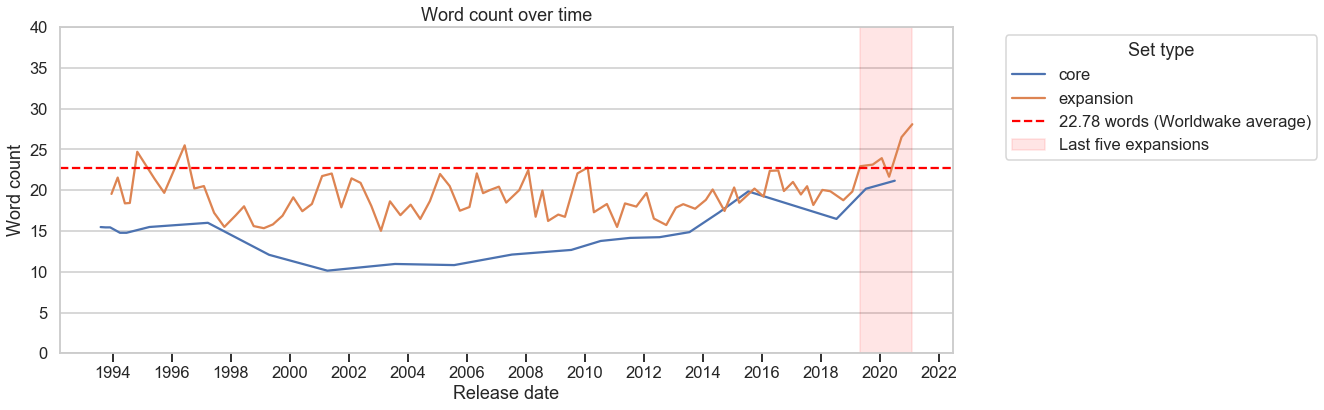

In [26]:
# Plot core and expansion sets by time.
fig, ax = plt.subplots(figsize=(16, 6))
ax.xaxis.grid(False)
ax.set_ylim((0, 40))
sns.lineplot(
    data=sets,
    x='released_at',
    y='word_count',
    hue='set_type',
    palette=sns.color_palette('deep', 2),
    ax=ax,
).set_title('Word count over time')
plt.axhline(y=22.78, c='red', linestyle='dashed', label="22.78 words (Worldwake average)")
plt.axvspan(
    pd.to_datetime('2019-05-03'), pd.to_datetime('2021-02-05'), alpha=.1, color='red',
    label="Last five expansions")
plt.legend(title='Set type', bbox_to_anchor=(1.05, 1))
plt.ylabel('Word count')
plt.xlabel('Release date')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.tick_params(axis='x', bottom=True)
plt.show()

This is super interesting. Between 1997 and 2019 expansion set averages have bounced around between 15 and 23 words. But there's been a big increase lately. **Five out of the six newest expansions are the wordiest sets released in ~25 years**. Even core sets have been creeping up in complexity, actually surpasing some expansions for the first time recently.

I'm super curious whether this trend corresponds with changes in the design team at WotC, or maybe it's an intentional change in design philosophy based on user research / feedback. Of course, it might just be a coincidence. Time will tell where the upcoming Strixhaven and subsequent expansions fall on this graph.

## The end, for now

Whelp, that was a lot of code and text and chonky plots. Thanks for hanging with me this far. I'd like to revisit this analysis in a while to see whether the trend towards more complex sets continues and to see what other fun ways WotC dreams up to complicate the data cleaning process.

You're welcome to use this code and [my card data snapshot]() to play around however you like. If you run into anything interesting I'd love to hear about it. And if you have any requests or ideas about extending this analysis please let me know. You can [tweet at me](https://twitter.com/Grae_Drake), pelt my inbox (<grae@grae.io>), or just keep up with what's new at [grae.io](grae.io).